In [1]:
%pip install opencv-python==3.4.2.17
%pip install opencv-contrib-python==3.4.2.17
# must restart after this command 

from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import getopt
import sys
import random

import scipy.io
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.5 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 5.9 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30

# <i><b><font color='blue'> I - KeyPoints, RANSAC, drawMatches </font></b></i>

In [2]:
# Extract Features(KeyPoints) :
def extract_features( img1, img2) :
    # sift :
    sift = cv2.xfeatures2d.SIFT_create()

    # feature matching :
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    kp1, desc1 = sift.detectAndCompute(img1,None)
    kp2, desc2 = sift.detectAndCompute(img2,None)

    matches = bf.match(desc1,desc2)
    matches = sorted(matches, key = lambda x:x.distance)

    keypoints = [kp1,kp2]

    # find features and keypoints :
    correspondenceList = []

    for match in matches:
        (x1, y1) = keypoints[0][match.queryIdx].pt
        (x2, y2) = keypoints[1][match.trainIdx].pt
        correspondenceList.append([x1, y1, x2, y2])

    corrs = np.matrix(correspondenceList)
    return corrs , kp1, kp2, matches

# Homography Estimation :
def calculateHomography(correspondences):
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h


# Calculate the geometric distance between estimated points and original points :
def geometricDistance(correspondence, h):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

# Runs through ransac algorithm, creating homographies from random correspondences :
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:   # 5 pixels , depends on image size , ...
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers


# Draw Correspendances :
def drawMatches(img1, kp1, img2, kp2, matches, inliers = None):
    corresp = []
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1,:] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:cols1+cols2,:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns, y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        inlier = False

        if inliers is not None:
            for i in inliers:
                if i.item(0) == x1 and i.item(1) == y1 and i.item(2) == x2 and i.item(3) == y2:
                    inlier = True

        ## Draw a small circle at both co-ordinates
        # cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        # cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points, draw inliers if we have them ( GBR)
        if inliers is not None and inlier:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 255, 0), 1)
            cv2.circle(out, (int(x1),int(y1)), 5, (255, 0, 0), 2) # added
            cv2.circle(out, (int(x2)+cols1,int(y2)), 5, (255, 0, 0), 2) # added
            corresp.append( [ ( int(x1), int(y1)), ( int(x2), int(y2) )] )

        # elif inliers is not None:  # R
            # cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 0, 255), 1)
        if inliers is None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1) 
            cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1) # added
            cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1) # added

    return out, corresp

# <i><b><font color='blue'> II - Stitching 2 images  </font></b></i>

Number of correspendances : 515 
 


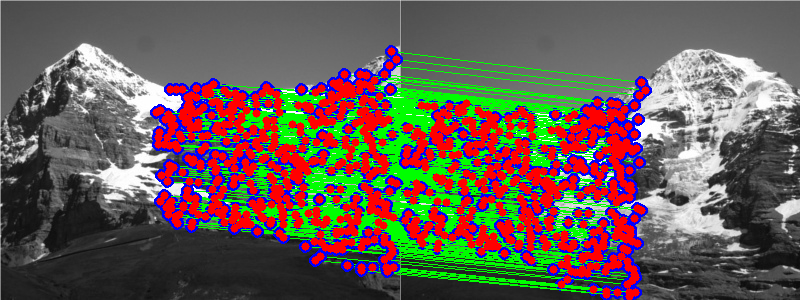

True

In [3]:
# from im_matches import extract_features, ransac, drawMatches :
path1 = '/content/gdrive/MyDrive/Computer_Vision/Homography/1Hill.JPG'
path2 = '/content/gdrive/MyDrive/Computer_Vision/Homography/2Hill.JPG'

img11 = cv2.imread( path1)  
img22 = cv2.imread( path2) 

img11 = cv2.cvtColor(img11, cv2.COLOR_BGR2RGB)
img22 = cv2.cvtColor(img22, cv2.COLOR_BGR2RGB)

img1 = cv2.cvtColor(img11, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img22, cv2.COLOR_BGR2GRAY)

corrs, kp1, kp2, matches = extract_features( img1, img2) 

# run ransac algorithm :
threshold = 0.50
finalH, inliers = ransac(corrs, threshold)

# final goal : img_of_matches, correspandences = func( img1, img2)
matchImg, corresp = drawMatches( img1, kp1, img2, kp2, matches, inliers)

print( 'Number of correspendances : {} \n '.format(len( corresp)) )

out_img = matchImg
cols1 = img1.shape[1]

for pair in corresp : 
  cv2.circle( out_img, pair[0], 4, ( 0, 0, 255), -1)
  cv2.circle( out_img, ( pair[1][0] + cols1, pair[1][1]), 4, ( 0, 0, 255), -1)

cv2_imshow( out_img)


cv2.imwrite( '/content/gdrive/MyDrive/Computer_Vision/Homography/MTCHS.JPG', out_img )

In [ ]:
obj = matches[0]
print( dict([attr, getattr(obj, attr)] for attr in dir(obj) if not attr.startswith('_')) )

{'distance': 27.422618865966797, 'imgIdx': 0, 'queryIdx': 13, 'trainIdx': 1141}


img shape : (300, 400) 
out shape : (328, 435) 


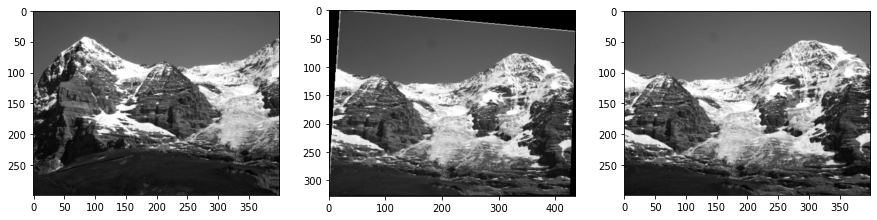

In [ ]:
import random 
from numpy.lib.type_check import nan_to_num

path = '/content/gdrive/MyDrive/Computer_Vision/Homography/2Hill.JPG'

img = cv2.imread( path)  
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print( 'img shape : {} '.format(img.shape) )

h_in = img.shape[0]
w_in = img.shape[1]

# Calculate Homography for N points (not just 4 pts)
L = []
for item in corresp:
    L.append( [ item[0][0], item[0][1], item[1][0], item[1][1]] )
C = np.matrix( L)
Hom = calculateHomography( C)


p_0 = np.dot( Hom, np.transpose(np.matrix([ 1, 1, 1])) )
p_1 = np.dot( Hom, np.transpose(np.matrix([ w_in, 1, 1])) )
p_2 = np.dot( Hom, np.transpose(np.matrix([ 1, h_in, 1])) )
p_3 = np.dot( Hom, np.transpose(np.matrix([ w_in, h_in, 1])) )

p_0 = p_0/p_0[2][0]
p_1 = p_1/p_1[2][0]
p_2 = p_2/p_2[2][0]
p_3 = p_3/p_3[2][0]

x_max = max( int(p_0[0][0]), int(p_1[0][0]), int(p_2[0][0]), int(p_3[0][0]) )
y_max = max( int(p_0[1][0]), int(p_1[1][0]), int(p_2[1][0]), int(p_3[1][0]) )

x_min = min( int(p_0[0][0]), int(p_1[0][0]), int(p_2[0][0]), int(p_3[0][0]) )
y_min = min( int(p_0[1][0]), int(p_1[1][0]), int(p_2[1][0]), int(p_3[1][0]) )

w_out = x_max - x_min + 1
h_out = y_max - y_min + 1 

out = np.zeros( [ h_out, w_out])
print( 'out shape : {} '.format(out.shape) )

for x in range( x_min, x_max+1):
    for y in range( y_min, y_max+1):
        p1 = np.transpose( np.matrix([ x, y, 1]))
        p2 = np.dot( np.linalg.inv( Hom), p1 )

        p =  p2/p2[2][0] 
        new_x = int(p[0][0]) 
        new_y = int(p[1][0]) 

        if ( 0 <= new_x < w_in) and (0 <= new_y < h_in ):
            out[y-y_min][x-x_min] = img[new_y][new_x]
        else:
            out[y-y_min][x-x_min] = 0


plt.figure( figsize= (15,10))
plt.subplot(131)
plt.imshow( img1, cmap = 'gray')
plt.subplot(132)
plt.imshow( out, cmap = 'gray')
plt.subplot(133)
plt.imshow( img2, cmap = 'gray')

out shape : (328, 584, 3) 


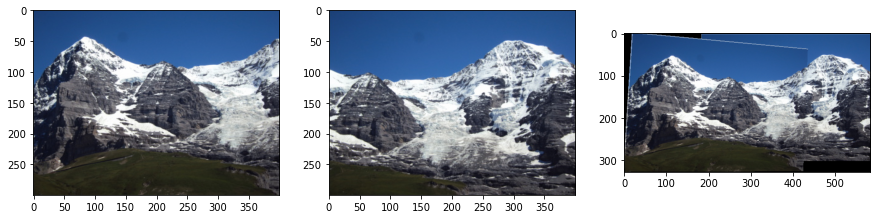

In [ ]:
# Image Warping : 2 images so far,
# This algorithm depend on the relative position ofthe 2 images, (left and right)

h_in_1 = img1.shape[0]
w_in_1 = img1.shape[1]

h_in_2 = img2.shape[0]
w_in_2 = img2.shape[1]

p_0 = np.dot( Hom, np.transpose(np.matrix([ 1, 1, 1])) )
p_1 = np.dot( Hom, np.transpose(np.matrix([ w_in_1, 1, 1])) )
p_2 = np.dot( Hom, np.transpose(np.matrix([ 1, h_in_1, 1])) )
p_3 = np.dot( Hom, np.transpose(np.matrix([ w_in_1, h_in_1, 1])) )

p_0 = p_0/p_0[2][0] 
p_1 = p_1/p_1[2][0]
p_2 = p_2/p_2[2][0]
p_3 = p_3/p_3[2][0]

# print( p_0, '\n\n', p_1, '\n\n', p_2, '\n\n', p_3 )

x_max = max( int(p_0[0][0]), int(p_1[0][0]), int(p_2[0][0]), int(p_3[0][0]), w_in_2 )
y_max = max( int(p_0[1][0]), int(p_1[1][0]), int(p_2[1][0]), int(p_3[1][0]), h_in_2 )

x_min = min( int(p_0[0][0]), int(p_1[0][0]), int(p_2[0][0]), int(p_3[0][0]), 0)
y_min = min( int(p_0[1][0]), int(p_1[1][0]), int(p_2[1][0]), int(p_3[1][0]), 0)

w_out = x_max - x_min + 1
h_out = y_max - y_min + 1 

res = np.zeros( [ h_out, w_out, 3], dtype= int)
print( 'out shape : {} '.format( res.shape) )

for x in range( x_min, x_max+1):
    for y in range( y_min, y_max+1):
        p1 = np.transpose( np.matrix([ x, y, 1]))
        p2 = np.dot( np.linalg.inv( Hom), p1 )

        p =  p2/p2[2][0] 
        new_x = int(p[0][0]) 
        new_y = int(p[1][0]) 

        for i in range(3):
            if ( 0 <= new_x < w_in_1) and (0 <= new_y < h_in_1 ) and ( 0 <= x < w_in_2) and (0 <= y < h_in_2 ):
                res[y-y_min][x-x_min][i] = int( img11[new_y][new_x][i])  #  ( img11[new_y][new_x][i] + img22[y][x][i])/2 
            elif ( 0 <= new_x < w_in_1) and (0 <= new_y < h_in_1 ):
                res[y-y_min][x-x_min][i] = int( img11[new_y][new_x][i] )
            elif ( 0 <= x < w_in_2) and (0 <= y < h_in_2 ):
                res[y-y_min][x-x_min][i] = int( img22[y][x][i] )
            else:
                res[y-y_min][x-x_min][i] = 0


plt.figure( figsize= (15,10))
plt.subplot(131)
plt.imshow( img11)
plt.subplot(132)
plt.imshow( img22)
plt.subplot(133)
plt.imshow( res)

# <i><b><font color='blue'> III - Stitching 3 images  </font></b></i>

In [ ]:
# from im_matches import extract_features, ransac, drawMatches :
path1 = '/content/gdrive/MyDrive/Computer_Vision/Homography/1Hill.JPG'
path2 = '/content/gdrive/MyDrive/Computer_Vision/Homography/2Hill.JPG'
path3 = '/content/gdrive/MyDrive/Computer_Vision/Homography/3Hill.JPG'

img11 = cv2.imread( path1)  
img22 = cv2.imread( path2) 
img33 = cv2.imread( path3) 

img11 = cv2.cvtColor(img11, cv2.COLOR_BGR2RGB)
img22 = cv2.cvtColor(img22, cv2.COLOR_BGR2RGB)
img33 = cv2.cvtColor(img33, cv2.COLOR_BGR2RGB)

img1 = cv2.cvtColor(img11, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img22, cv2.COLOR_BGR2GRAY)
img3 = cv2.cvtColor(img33, cv2.COLOR_BGR2GRAY)

# matches img1 -> img2 :
corrs, kp1, kp2, matches = extract_features( img1, img2) 
threshold = 0.50
finalH, inliers = ransac(corrs, threshold)
imgMatch, corresp12 = drawMatches( img1, kp1, img2, kp2, matches, inliers)

# matches img3 -> img2 :
corrs, kp1, kp2, matches = extract_features( img3, img2) 
threshold = 0.50
finalH, inliers = ransac(corrs, threshold)
imgMatch, corresp32 = drawMatches( img3, kp1, img2, kp2, matches, inliers)

In [ ]:
import random 
from numpy.lib.type_check import nan_to_num

# Calculate Homography for N points (not just 4 pts)
L = []
for item in corresp12:
    L.append( [ item[0][0], item[0][1], item[1][0], item[1][1]] )
C = np.matrix( L)
Hom12 = calculateHomography( C)

L = []
for item in corresp32:
    L.append( [ item[0][0], item[0][1], item[1][0], item[1][1]] )
C = np.matrix( L)
Hom32 = calculateHomography( C)

In [ ]:
# Image Warping : 2 images so far,
# This algorithm depend on the relative position ofthe 2 images, (left and right)
# img2 is the main image : img1(adapted) | img2 | img3(adapted)

h_in_1 = img1.shape[0]
w_in_1 = img1.shape[1]

h_in_2 = img2.shape[0]
w_in_2 = img2.shape[1]

h_in_3 = img3.shape[0]
w_in_3 = img3.shape[1]

pts1 = [ [ 1, 1, 1], [ w_in_1, 1, 1], [ 1, h_in_1, 1], [ w_in_1, h_in_1, 1] ]
pts3 = [ [ 1, 1, 1], [ w_in_3, 1, 1], [ 1, h_in_3, 1], [ w_in_3, h_in_3, 1] ]

pts12 = pts1
for i in range( len(pts1)):
    pts12[i] = np.dot( Hom12, np.transpose(np.matrix( pts1[i])) )
    pts12[i] = pts12[i]/pts12[i][2][0]

pts32 = pts3
for i in range( len(pts3)):
    pts32[i] = np.dot( Hom32, np.transpose(np.matrix( pts3[i])) )
    pts32[i] = pts32[i]/pts32[i][2][0]

x_max = max( int(pts12[0][0][0]), int(pts12[1][0][0]), int(pts12[2][0][0]), int(pts12[3][0][0]), w_in_2 )
y_max = max( int(pts12[0][1][0]), int(pts12[1][1][0]), int(pts12[2][1][0]), int(pts12[3][1][0]), h_in_2 )

x_min = min( int(pts12[0][0][0]), int(pts12[1][0][0]), int(pts12[2][0][0]), int(pts12[3][0][0]), 0)
y_min = min( int(pts12[0][1][0]), int(pts12[1][1][0]), int(pts12[2][1][0]), int(pts12[3][1][0]), 0)

x_max = max( int(pts32[0][0][0]), int(pts32[1][0][0]), int(pts32[2][0][0]), int(pts32[3][0][0]), x_max)
y_max = max( int(pts32[0][1][0]), int(pts32[1][1][0]), int(pts32[2][1][0]), int(pts32[3][1][0]), y_max )

x_min = min( int(pts32[0][0][0]), int(pts32[1][0][0]), int(pts32[2][0][0]), int(pts32[3][0][0]), x_min)
y_min = min( int(pts32[0][1][0]), int(pts32[1][1][0]), int(pts32[2][1][0]), int(pts32[3][1][0]), y_min)

w_out = x_max - x_min + 1
h_out = y_max - y_min + 1 

res = np.zeros( [ h_out, w_out, 3], dtype= int)
print( 'out shape : {} '.format( res.shape) )

for x in range( x_min, x_max+1):
    for y in range( y_min, y_max+1):
        p1 = np.transpose( np.matrix([ x, y, 1]))
        p2 = np.dot( np.linalg.inv( Hom12), p1 )

        p =  p2/p2[2][0] 
        new_x_12 = int(p[0][0]) 
        new_y_12 = int(p[1][0]) 

        p2 = np.dot( np.linalg.inv( Hom32), p1 )

        p =  p2/p2[2][0] 
        new_x_32 = int(p[0][0]) 
        new_y_32 = int(p[1][0]) 

        for i in range(3):  # 3 -> RGB
            if ( 0 <= new_x_12 < w_in_1) and (0 <= new_y_12 < h_in_1 ) :
                res[y-y_min][x-x_min][i] = int( img11[new_y_12][new_x_12][i]) 
            elif ( 0 <= new_x_32 < w_in_3) and (0 <= new_y_32 < h_in_3 ):
                res[y-y_min][x-x_min][i] = int( img33[new_y_32][new_x_32][i] )
            elif ( 0 <= x < w_in_2) and (0 <= y < h_in_2 ):
                res[y-y_min][x-x_min][i] = int( img22[y][x][i] )
            else:
                res[y-y_min][x-x_min][i] = 0

out shape : (364, 741, 3) 


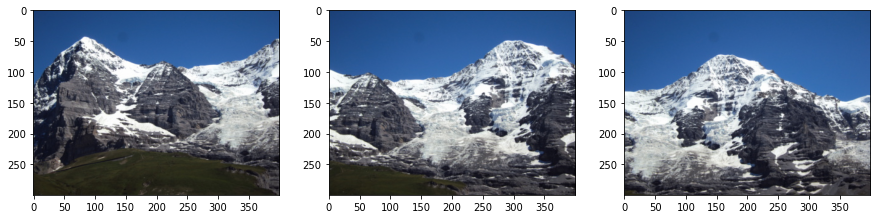

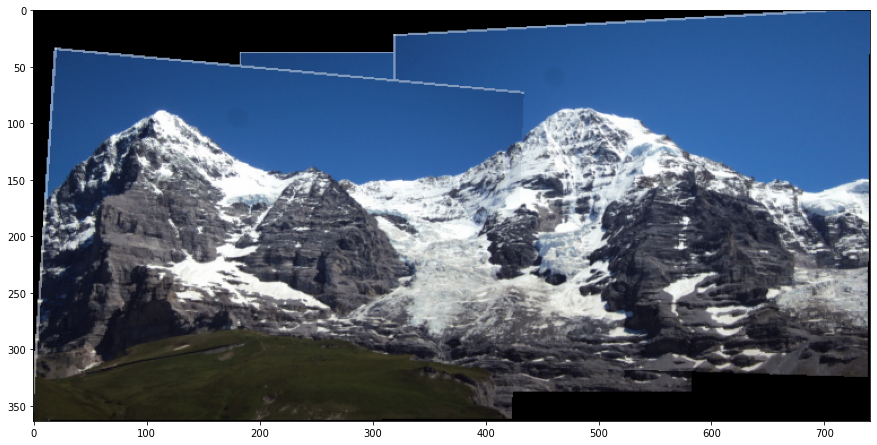

In [ ]:
plt.figure( figsize= (15,10))
plt.subplot(131)
plt.imshow( img11)
plt.subplot(132)
plt.imshow( img22)
plt.subplot(133)
plt.imshow( img33)

plt.figure( figsize= (15,10))
plt.imshow( res)

In [ ]:
res = res.astype( np.uint8)
plt.imsave('/content/gdrive/MyDrive/Computer_Vision/Homography/res.JPG', res)